# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Autoencoders 

In [58]:
# torch modules
import torch
import torch.nn as nn
import torch.optim as toptim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# sklearn and skorch modules
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from skorch import NeuralNetRegressor,NeuralNetClassifier,callbacks

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# optuna import
import optuna

# self-made libraries import
from encoders import Encoder
from decoders import Decoder
from training_func import training_loop, training_loop_sup, training_loop_autoenc, training_loop_den
from optimization import objective
from utilities import plot_result, add_noise

In [57]:
import sys, importlib
importlib.reload(sys.modules['encoders'])
importlib.reload(sys.modules["training_func"])
importlib.reload(sys.modules["optimization"])
importlib.reload(sys.modules["utilities"])

<module 'utilities' from 'c:\\Users\\Filippo\\Documents\\POD\\Projects\\NNDL\\HW2\\utilities.py'>

## Dataset

In [53]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)) , transforms.ToTensor() ])

# loading train and test dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

train_dataset.transform = transformations
test_dataset.transform = transformations


In [54]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


## Network definition

In [10]:
### Set the random seed for reproducible results
torch.manual_seed(0)
device = "cpu"
### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim,device=device)
decoder = Decoder(encoded_space_dim=encoded_space_dim, device=device)

# Training parameters

In [52]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)


In [12]:
encoder,decoder,train_loss,test_loss = training_loop(10,device,encoder,decoder,train_dataloader,test_dataloader,loss_fn,optim)

EPOCH 1/10


	 VALIDATION - EPOCH 1/10 - loss: 0.065332


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - loss: 0.053759


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - loss: 0.048455


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - loss: 0.046704


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - loss: 0.045746


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - loss: 0.045304


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - loss: 0.044695


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - loss: 0.044370


EPOCH 9/10


	 VALIDATION - EPOCH 9/10 - loss: 0.044150


EPOCH 10/10


	 VALIDATION - EPOCH 10/10 - loss: 0.043643




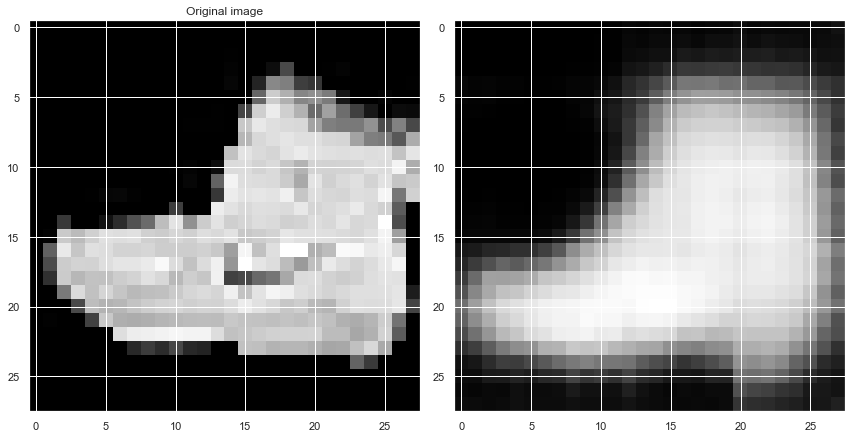

In [16]:
im=train_dataset[0][0][0]
rec_im=decoder(encoder(train_dataset[0][0].reshape([1,1,28,28])))[0][0].detach()
plot_result(im,rec_im)

# Optuna optimization

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.tail(5)

In [ ]:
optuna.visualization.plot_optimization_history(study)

# Denoising

In [59]:
### Set the random seed for reproducible results
torch.manual_seed(0)
device = "cpu"
### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim,device=device)
decoder = Decoder(encoded_space_dim=encoded_space_dim, device=device)

In [60]:
encoder,decoder,train_loss,test_loss = training_loop_den(10,device,encoder,decoder,train_dataloader,test_dataloader,loss_fn,optim)

EPOCH 1/10


	 VALIDATION - EPOCH 1/10 - loss: 0.180603


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - loss: 0.180447


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - loss: 0.180456


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - loss: 0.180542


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - loss: 0.180426


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - loss: 0.180521


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - loss: 0.180550


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - loss: 0.180441


EPOCH 9/10


	 VALIDATION - EPOCH 9/10 - loss: 0.180456


EPOCH 10/10


	 VALIDATION - EPOCH 10/10 - loss: 0.180493




# Supervised learning application

In [20]:
from conv_model import ConvolutionalNet
classifierNet = ConvolutionalNet(act_func=nn.ReLU(), linear_size=120, conv0_size = 10, conv1_size = 20, dropout=0.2)


In [21]:
net_skorch = NeuralNetClassifier(
            module=classifierNet,
            module__act_func=nn.ReLU(),
            criterion= nn.CrossEntropyLoss,
            max_epochs=20,
            optimizer__lr = 1e-3,
            optimizer = torch.optim.Adam,
            batch_size = 1000,
            # optimizer__weight_decay=0.01, # L2 Regularization          
            # train_split
            # device='cuda',  # uncomment this to train with CUDA
            callbacks = [callbacks.EarlyStopping(monitor='valid_loss', patience=100, threshold=0.005)],     
            verbose = 0
)

In [22]:
input_data = train_dataset.data.type(torch.float32).reshape(60000,1,28,28)
label_data = train_dataset.targets.type(torch.int64).reshape(60000)
net_skorch.fit(input_data,label_data)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvolutionalNet(
    (act_func): ReLU()
    (final_func): Softmax(dim=1)
    (dropout_func): Dropout(p=0, inplace=False)
    (conv0): Conv2d(1, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lin_layer): Linear(in_features=1280, out_features=100, bias=True)
    (out_layer): Linear(in_features=100, out_features=10, bias=True)
  ),
)

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
encoder,decoder,train_loss,test_loss = training_loop_sup(10,device,encoder,decoder,train_dataloader,test_dataloader,loss_fn,optim, classifierNet)

EPOCH 1/10


c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\training_func.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(classifierNet.forward(decoded_data), torch.nn.functional.one_hot(torch.tensor(image_label),num_classes=10).type(torch.float32))
c:\Users\Filippo\Documents\POD\Projects\NNDL\HW2\training_func.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = loss_fn(classifierNet.forward(conc_out), torch.nn.functional.one_hot(torch.tensor(conc_label),num_classes=10).type(torch.float32))




	 VALIDATION - EPOCH 1/10 - loss: 2.300492


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - loss: 2.298317


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - loss: 2.296957


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - loss: 2.296364


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - loss: 2.295939


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - loss: 2.295702


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - loss: 2.295569


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - loss: 2.295240


EPOCH 9/10


KeyboardInterrupt: 

# Network analysis

In [ ]:
# losses plot
f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
sns.lineplot(x=np.arange(len(val_loss)),y=val_loss, label='Validation loss',markers=True, ax=ax)

ax.set_yscale("log")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
import plotly.express as px
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

In [ ]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

In [ ]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

# Variational Autoencoder

In [26]:
encoder = Encoder(encoded_space_dim=4)
decoder = Decoder(encoded_space_dim=2)
loss_fn = torch.nn.MSELoss()

In [27]:
encoder,decoder,train_loss,test_loss = training_loop_autoenc(10,device,encoder,decoder,train_dataloader,test_dataloader,loss_fn,optim)

EPOCH 1/10


	 VALIDATION - EPOCH 1/10 - loss: 0.155250


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - loss: 0.155236


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - loss: 0.155263


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - loss: 0.155225


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - loss: 0.155191


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - loss: 0.155208


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - loss: 0.155244


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - loss: 0.155210


EPOCH 9/10


	 VALIDATION - EPOCH 9/10 - loss: 0.155222


EPOCH 10/10


	 VALIDATION - EPOCH 10/10 - loss: 0.155204


